##### Import commands

In [1]:
import pandas as pd
import numpy as np
import zipcodes
import requests
import datetime as dt
import sklearn as sk
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import matplotlib.cm as cm
from neo4j import GraphDatabase
from collections import defaultdict
from sklearn.metrics import confusion_matrix
import seaborn as sns


## CSV Read/Write and Dataframe Declaration

In [2]:
# reads in original csv file of most recent trip data to maintain relevance
df_bluebikes = pd.read_csv('data/202303-bluebikes-tripdata.csv')
df_bluebikes

# filter out stations by postal code
# 30 minute intervals
print(df_bluebikes.shape)
df_bluebikes.head(10)

df_all_trips = df_bluebikes.copy()

(199003, 14)


In [3]:
# reads in the current bluebike stations csv
df_cur_stations = pd.read_csv('data/current_bluebikes_stations.csv', header=1)
df_cur_stations

,Number,Name,Latitude,Longitude,District,Public,Total docks,Deployment Year
0,K32015,1200 Beacon St,42.344149,-71.114674,Brookline,Yes,15,2021.0
1,W32006,160 Arsenal,42.364664,-71.175694,Watertown,Yes,11,2021.0
2,A32019,175 N Harvard St,42.363796,-71.129164,Boston,Yes,17,2014.0
3,S32035,191 Beacon St,42.380323,-71.108786,Somerville,Yes,19,2018.0
4,C32094,2 Hummingbird Lane at Olmsted Green,42.288870,-71.095003,Boston,Yes,17,2020.0
...,...,...,...,...,...,...,...,...
443,N32005,West Newton,42.349601,-71.226275,Newton,Yes,14,2020.0
444,A32043,Western Ave at Richardson St,42.361787,-71.143931,Boston,Yes,0,2019.0
445,B32059,Whittier St Health Center,42.332863,-71.092189,Boston,Yes,19,2019.0
446,D32040,Williams St at Washington St,42.306539,-71.107669,Boston,Yes,23,2018.0


In [4]:
list(df_bluebikes['end station name'].values)

# finds the set of stations that are not shared in both datasets
set_names = set()

for name in df_bluebikes['end station name'].values:
    if name in df_cur_stations['Name'].values:
        pass
    else:
        set_names.add(name)

In [5]:
set_names

{'18 Dorrance Warehouse',
 '87-101 Cambridgepark Drive',
 'Ball Sq',
 'Beacon St at Washington / Kirkland',
 'Boylston St at Charles St (Temp Winter Location)',
 'Boynton Yards at 101 South Street',
 'Broadway T Stop',
 'Craigie at Summer St',
 'Graham and Parks School – Linnaean St at Walker St',
 'Linear Park - Mass. Ave. at Cameron Ave. ',
 'Riverway at Brookline Ave',
 'Somerville Hospital',
 'Washington St at Myrtle St'}

In [6]:
# changes the naming conventions to match the stations across both datasets
df_cur_stations['Name'] = df_cur_stations['Name'].replace('Graham and Parks School ? Linnaean St at Walker St',
                                          'Graham and Parks School - Linnaean St at Walker St')
df_cur_stations['Name'] = df_cur_stations['Name'].replace('Linear Park - Mass. Ave. at Cameron Ave.',
                                          'Linear Park - Mass. Ave. at Cameron Ave. ')
df_cur_stations['Name'] = df_cur_stations['Name'].replace('Boylston St at Charles St (Temp Winter Location)',
                                          'Boylston St at Charles St')
df_cur_stations

,Number,Name,Latitude,Longitude,District,Public,Total docks,Deployment Year
0,K32015,1200 Beacon St,42.344149,-71.114674,Brookline,Yes,15,2021.0
1,W32006,160 Arsenal,42.364664,-71.175694,Watertown,Yes,11,2021.0
2,A32019,175 N Harvard St,42.363796,-71.129164,Boston,Yes,17,2014.0
3,S32035,191 Beacon St,42.380323,-71.108786,Somerville,Yes,19,2018.0
4,C32094,2 Hummingbird Lane at Olmsted Green,42.288870,-71.095003,Boston,Yes,17,2020.0
...,...,...,...,...,...,...,...,...
443,N32005,West Newton,42.349601,-71.226275,Newton,Yes,14,2020.0
444,A32043,Western Ave at Richardson St,42.361787,-71.143931,Boston,Yes,0,2019.0
445,B32059,Whittier St Health Center,42.332863,-71.092189,Boston,Yes,19,2019.0
446,D32040,Williams St at Washington St,42.306539,-71.107669,Boston,Yes,23,2018.0


In [7]:
df_cur_stations

,Number,Name,Latitude,Longitude,District,Public,Total docks,Deployment Year
0,K32015,1200 Beacon St,42.344149,-71.114674,Brookline,Yes,15,2021.0
1,W32006,160 Arsenal,42.364664,-71.175694,Watertown,Yes,11,2021.0
2,A32019,175 N Harvard St,42.363796,-71.129164,Boston,Yes,17,2014.0
3,S32035,191 Beacon St,42.380323,-71.108786,Somerville,Yes,19,2018.0
4,C32094,2 Hummingbird Lane at Olmsted Green,42.288870,-71.095003,Boston,Yes,17,2020.0
...,...,...,...,...,...,...,...,...
443,N32005,West Newton,42.349601,-71.226275,Newton,Yes,14,2020.0
444,A32043,Western Ave at Richardson St,42.361787,-71.143931,Boston,Yes,0,2019.0
445,B32059,Whittier St Health Center,42.332863,-71.092189,Boston,Yes,19,2019.0
446,D32040,Williams St at Washington St,42.306539,-71.107669,Boston,Yes,23,2018.0


In [8]:
filtered_zips = zipcodes.filter_by(city="Boston", state="MA") 
filtered_zips

# finds a list of the zipcodes in Boston to filter by region
boston_zips_list = []

for i in filtered_zips:
    boston_zips_list.append(i['zip_code'])
    
len(boston_zips_list)

37

In [9]:
# filters the dataset to only include Boston region
df_cur_stations = df_cur_stations.loc[df_cur_stations['District'] == 'Boston']
df_cur_stations

,Number,Name,Latitude,Longitude,District,Public,Total docks,Deployment Year
2,A32019,175 N Harvard St,42.363796,-71.129164,Boston,Yes,17,2014.0
4,C32094,2 Hummingbird Lane at Olmsted Green,42.288870,-71.095003,Boston,Yes,17,2020.0
8,C32106,555 Metropolitan Ave,42.268100,-71.119240,Boston,Yes,18,2021.0
9,C32105,606 American Legion Hwy at Canterbury St,42.285780,-71.109725,Boston,Yes,18,2021.0
10,C32091,645 Summer St,42.341781,-71.039870,Boston,Yes,19,2020.0
...,...,...,...,...,...,...,...,...
441,B32021,Wentworth Institute of Technology - Huntington...,42.337586,-71.096271,Boston,Yes,14,2015.0
442,D32022,West End Park,42.365908,-71.064467,Boston,Yes,35,2012.0
444,A32043,Western Ave at Richardson St,42.361787,-71.143931,Boston,Yes,0,2019.0
445,B32059,Whittier St Health Center,42.332863,-71.092189,Boston,Yes,19,2019.0


Speeding up station lookup using a dictionary:

In [10]:
bos_station_dict = {}
for idx, s in df_cur_stations.iterrows():
    bos_station_dict[s['Name']] = idx
print(bos_station_dict)

{'175 N Harvard St': 2, '2 Hummingbird Lane at Olmsted Green': 4, '555 Metropolitan Ave': 8, '606 American Legion Hwy at Canterbury St': 9, '645 Summer St': 10, '700 Commonwealth Ave.': 13, 'Adams Branch Library': 19, 'Adams St at Lonsdale St': 20, 'Addison St at Saratoga St': 21, 'Airport T Stop - Bremen St at Brooks St': 22, 'Albany St at E. Brookline St': 23, 'American Legion Hwy at Cummins Hwy': 26, 'American Legion Hwy at Hyde Park Ave': 27, 'Andrew T Stop - Dorchester Ave at Dexter St': 30, 'Aquarium T Stop - 200 Atlantic Ave': 31, 'Arch St at Franklin St': 32, 'Archdale Rd at Washington St': 33, 'Ashmont T Stop': 35, 'B.U. Central - 725 Comm. Ave.': 38, 'Back Bay T Stop - Dartmouth St at Stuart St': 39, 'Bartlett St at John Elliot Sq': 41, 'Beacon St at Charles St': 43, 'Beacon St at Massachusetts Ave': 44, 'Belgrade Ave at Walworth St': 46, 'Bellevue T Stop': 47, 'Bennington St at Byron St': 49, 'Bennington St at Constitution Beach': 50, 'Blossom St at Charles St': 53, 'Blue Hi

In [11]:
# filters the history data by Boston region
df_bluebikes = df_bluebikes.loc[df_bluebikes['postal code'].isin(boston_zips_list)]
df_bluebikes

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,postal code
2,169,2023-03-01 00:03:54.2260,2023-03-01 00:06:43.6980,12,Ruggles T Stop - Columbus Ave at Melnea Cass Blvd,42.336244,-71.087986,160,Wentworth Institute of Technology - Huntington...,42.337586,-71.096271,4727,Subscriber,02115
6,372,2023-03-01 00:05:42.5770,2023-03-01 00:11:54.8490,554,Forsyth St at Huntington Ave,42.339202,-71.090511,379,Tremont St at W. Dedham St,42.342549,-71.074214,7441,Subscriber,02118
11,593,2023-03-01 00:11:32.6930,2023-03-01 00:21:26.0270,554,Forsyth St at Huntington Ave,42.339202,-71.090511,558,St. Alphonsus St at Tremont St,42.333293,-71.101246,7345,Subscriber,02115
25,349,2023-03-01 00:21:39.2690,2023-03-01 00:27:28.9750,554,Forsyth St at Huntington Ave,42.339202,-71.090511,27,Roxbury Crossing T Stop - Columbus Ave at Trem...,42.331184,-71.095171,3743,Subscriber,02118
32,1086,2023-03-01 00:30:26.3020,2023-03-01 00:48:32.3410,68,Central Square at Mass Ave / Essex St,42.365070,-71.103100,14,HMS/HSPH - Avenue Louis Pasteur at Longwood Ave,42.337417,-71.102861,8473,Subscriber,02115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198985,201,2023-03-31 23:48:14.5630,2023-03-31 23:51:35.9330,228,One Memorial Drive,42.361619,-71.080436,60,Charles Circle - Charles St at Cambridge St,42.360793,-71.071190,3660,Subscriber,02114
198990,769,2023-03-31 23:52:43.2290,2023-04-01 00:05:33.0910,338,Commonwealth Ave at Kelton St,42.348359,-71.139972,19,Park Dr at Buswell St,42.347241,-71.105301,7315,Subscriber,02215
198991,3711,2023-03-31 23:52:49.1240,2023-04-01 00:54:40.2120,128,E Cottage St at Columbia Rd,42.320561,-71.061980,128,E Cottage St at Columbia Rd,42.320561,-71.061980,4446,Subscriber,02109
198995,2663,2023-03-31 23:54:24.0930,2023-04-01 00:38:47.3720,9,Commonwealth Ave at Agganis Way,42.351692,-71.119035,9,Commonwealth Ave at Agganis Way,42.351692,-71.119035,7701,Customer,02215


In [12]:
# saves to csv
df_bluebikes.to_csv('data/boston_202303_bluebikes_tripdata.csv')
df_cur_stations.to_csv('data/boston_current_bluebike_stations.csv')

In [13]:
# reads in the updated csv
df_bluebikes = pd.read_csv('data/boston_202303_bluebikes_tripdata.csv')
df_cur_stations = pd.read_csv('data/boston_current_bluebike_stations.csv')

## JSON Testing

In [14]:
request = requests.get("https://gbfs.bluebikes.com/gbfs/en/station_information.json")
print(request.json())

{'data': {'stations': [{'legacy_id': '3', 'eightd_has_key_dispenser': True, 'region_id': '10', 'electric_bike_surcharge_waiver': False, 'station_id': '3', 'capacity': 14, 'short_name': 'B32006', 'lat': 42.34011512249236, 'external_id': 'f83464e4-0de8-11e7-991c-3863bb43a7d0', 'has_kiosk': True, 'rental_methods': ['KEY', 'CREDITCARD'], 'station_type': 'classic', 'eightd_station_services': [], 'name': 'Colleges of the Fenway - Fenway at Avenue Louis Pasteur', 'lon': -71.10061883926392}, {'legacy_id': '4', 'eightd_has_key_dispenser': False, 'region_id': '10', 'electric_bike_surcharge_waiver': False, 'station_id': '4', 'capacity': 19, 'short_name': 'C32000', 'lat': 42.345392, 'external_id': 'f834658f-0de8-11e7-991c-3863bb43a7d0', 'has_kiosk': True, 'rental_methods': ['KEY', 'CREDITCARD'], 'station_type': 'classic', 'eightd_station_services': [], 'name': 'Tremont St at E Berkeley St', 'lon': -71.069616}, {'legacy_id': '5', 'eightd_has_key_dispenser': False, 'region_id': '10', 'electric_bike_

In [15]:
request.json()['data']['stations'][100]

{'legacy_id': '111',
 'eightd_has_key_dispenser': False,
 'region_id': '9',
 'electric_bike_surcharge_waiver': False,
 'station_id': '111',
 'capacity': 15,
 'short_name': 'S32009',
 'lat': 42.40449,
 'external_id': 'f834c6f5-0de8-11e7-991c-3863bb43a7d0',
 'has_kiosk': True,
 'rental_methods': ['KEY', 'CREDITCARD'],
 'station_type': 'classic',
 'eightd_station_services': [],
 'name': 'Packard Ave at Powderhouse Blvd',
 'lon': -71.123413}

In [16]:
kiosk_list = []
for i in request.json()['data']['stations']:
    kiosk_list.append(i['has_kiosk'])
    
kiosk_list[:10]

[True, True, True, True, True, True, True, True, True, True]

In [17]:
request2 = requests.get("https://gbfs.bluebikes.com/gbfs/fr/free_bike_status.json")
request2.json()

{'data': {'bikes': []}, 'last_updated': 1681716025, 'ttl': 5}

In [18]:
request3 = requests.get("https://gbfs.bluebikes.com/gbfs/en/system_calendar.json")
request3.json()

{'data': {'calendars': [{'end_month': 12,
    'end_day': 31,
    'start_month': 1,
    'start_day': 1}]},
 'last_updated': 1681716025,
 'ttl': 5}

## Deriving Attributes: Date and Time

In [19]:
df_bluebikes['starttime'] = df_bluebikes['starttime'].apply(lambda x : dt.datetime.strptime(x, 
                                              '%Y-%m-%d %H:%M:%S.%f'))
df_bluebikes['stoptime'] = df_bluebikes['stoptime'].apply(lambda x : dt.datetime.strptime(x, 
                                              '%Y-%m-%d %H:%M:%S.%f'))

In [20]:
df_bluebikes['day_of_week'] = df_bluebikes['starttime'].dt.dayofweek

In [21]:
df_bluebikes.loc[df_bluebikes['start station name'] == '175 N Harvard St']

,Unnamed: 0,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,postal code,day_of_week
1188,6087,666,2023-03-01 20:43:44.397,2023-03-01 20:54:50.763,149,175 N Harvard St,42.363796,-71.129164,103,JFK Crossing at Harvard St. / Thorndike St.,42.346551,-71.128332,6487,Subscriber,2215,2
1855,9941,879,2023-03-02 17:50:56.137,2023-03-02 18:05:35.422,149,175 N Harvard St,42.363796,-71.129164,69,Coolidge Corner - Beacon St at Centre St,42.341598,-71.123338,8202,Subscriber,2215,3
2175,11626,2183,2023-03-02 20:21:45.612,2023-03-02 20:58:09.070,149,175 N Harvard St,42.363796,-71.129164,591,515 Somerville Ave (Temp. Winter Location),42.383227,-71.106069,2509,Subscriber,2163,3
2189,11732,272,2023-03-02 20:38:13.216,2023-03-02 20:42:45.229,149,175 N Harvard St,42.363796,-71.129164,17,Soldiers Field Park - 111 Western Ave,42.364263,-71.118276,6751,Subscriber,2163,3
2825,15286,548,2023-03-03 14:19:51.690,2023-03-03 14:29:00.611,149,175 N Harvard St,42.363796,-71.129164,108,Harvard University / SEAS Cruft-Pierce Halls a...,42.377945,-71.116865,6720,Subscriber,2163,4
3005,16299,494,2023-03-03 16:44:23.522,2023-03-03 16:52:37.624,149,175 N Harvard St,42.363796,-71.129164,74,Harvard Square at Mass Ave/ Dunster,42.373268,-71.118579,6472,Subscriber,2215,4
3735,20537,385,2023-03-04 17:21:07.836,2023-03-04 17:27:33.636,149,175 N Harvard St,42.363796,-71.129164,17,Soldiers Field Park - 111 Western Ave,42.364263,-71.118276,3866,Subscriber,2163,5
5866,32756,101,2023-03-06 20:36:01.221,2023-03-06 20:37:43.179,149,175 N Harvard St,42.363796,-71.129164,29,Innovation Lab - 125 Western Ave at Batten Way,42.363713,-71.124598,4462,Subscriber,2163,0
6448,35717,542,2023-03-07 12:30:00.843,2023-03-07 12:39:03.327,149,175 N Harvard St,42.363796,-71.129164,103,JFK Crossing at Harvard St. / Thorndike St.,42.346551,-71.128332,3034,Subscriber,2115,1
6898,38204,706,2023-03-07 18:53:49.637,2023-03-07 19:05:36.091,149,175 N Harvard St,42.363796,-71.129164,103,JFK Crossing at Harvard St. / Thorndike St.,42.346551,-71.128332,2547,Subscriber,2215,1


In [22]:
df_bluebikes.to_csv('data/boston_bluebikes_202303_datetimes.csv')

In [23]:
len(pd.unique(df_cur_stations['Number']))

250

In [24]:
df_cur_stations

,Unnamed: 0,Number,Name,Latitude,Longitude,District,Public,Total docks,Deployment Year
0,2,A32019,175 N Harvard St,42.363796,-71.129164,Boston,Yes,17,2014.0
1,4,C32094,2 Hummingbird Lane at Olmsted Green,42.288870,-71.095003,Boston,Yes,17,2020.0
2,8,C32106,555 Metropolitan Ave,42.268100,-71.119240,Boston,Yes,18,2021.0
3,9,C32105,606 American Legion Hwy at Canterbury St,42.285780,-71.109725,Boston,Yes,18,2021.0
4,10,C32091,645 Summer St,42.341781,-71.039870,Boston,Yes,19,2020.0
...,...,...,...,...,...,...,...,...,...
245,441,B32021,Wentworth Institute of Technology - Huntington...,42.337586,-71.096271,Boston,Yes,14,2015.0
246,442,D32022,West End Park,42.365908,-71.064467,Boston,Yes,35,2012.0
247,444,A32043,Western Ave at Richardson St,42.361787,-71.143931,Boston,Yes,0,2019.0
248,445,B32059,Whittier St Health Center,42.332863,-71.092189,Boston,Yes,19,2019.0


### Dividing into time buckets

In [25]:
df_bluebikes['starttime'].max()

Timestamp('2023-03-31 23:58:04.497000')

In [26]:
def perdelta(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta

timestamps = list(perdelta(dt.datetime(2023, 3, 1, 0), dt.datetime(2023, 4, 1, 0), dt.timedelta(hours=1)))

In [27]:
timestamps[:10]

[datetime.datetime(2023, 3, 1, 0, 0),
 datetime.datetime(2023, 3, 1, 1, 0),
 datetime.datetime(2023, 3, 1, 2, 0),
 datetime.datetime(2023, 3, 1, 3, 0),
 datetime.datetime(2023, 3, 1, 4, 0),
 datetime.datetime(2023, 3, 1, 5, 0),
 datetime.datetime(2023, 3, 1, 6, 0),
 datetime.datetime(2023, 3, 1, 7, 0),
 datetime.datetime(2023, 3, 1, 8, 0),
 datetime.datetime(2023, 3, 1, 9, 0)]

In [28]:
stations = list(df_cur_stations['Name'])

In [29]:
dict_main = {'station' : [], 'timestamp' : [], 'weekday' : [], 'hour' : []}
for station in stations:
    for timestamp in timestamps:
        dict_main['station'].append(station)
        dict_main['timestamp'].append(timestamp)
        dict_main['weekday'].append(timestamp.weekday())
        dict_main['hour'].append(timestamp.hour)
dict_main

{'station': ['175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',
  '175 N Harvard St',

In [30]:
df_main = pd.DataFrame(dict_main)
df_main

,station,timestamp,weekday,hour
0,175 N Harvard St,2023-03-01 00:00:00,2,0
1,175 N Harvard St,2023-03-01 01:00:00,2,1
2,175 N Harvard St,2023-03-01 02:00:00,2,2
3,175 N Harvard St,2023-03-01 03:00:00,2,3
4,175 N Harvard St,2023-03-01 04:00:00,2,4
...,...,...,...,...
185995,Williams St at Washington St,2023-03-31 19:00:00,4,19
185996,Williams St at Washington St,2023-03-31 20:00:00,4,20
185997,Williams St at Washington St,2023-03-31 21:00:00,4,21
185998,Williams St at Washington St,2023-03-31 22:00:00,4,22


## Deriving Dock Counts

In [31]:
df_main['docks'] = 0

In [32]:
df_main

,station,timestamp,weekday,hour,docks
0,175 N Harvard St,2023-03-01 00:00:00,2,0,0
1,175 N Harvard St,2023-03-01 01:00:00,2,1,0
2,175 N Harvard St,2023-03-01 02:00:00,2,2,0
3,175 N Harvard St,2023-03-01 03:00:00,2,3,0
4,175 N Harvard St,2023-03-01 04:00:00,2,4,0
...,...,...,...,...,...
185995,Williams St at Washington St,2023-03-31 19:00:00,4,19,0
185996,Williams St at Washington St,2023-03-31 20:00:00,4,20,0
185997,Williams St at Washington St,2023-03-31 21:00:00,4,21,0
185998,Williams St at Washington St,2023-03-31 22:00:00,4,22,0


The commented code below was meant to check whether EITHER the start or end stations are in Boston (rather than both). The problem here is likely that the system autofilters mass bike movement done by Bluebike employees. In other words, many people may bike from Boston to Cambridge, but not bike back, so employees need to bring the bikes back to Boston (which is not logged in the trip records).

In [33]:
"""
TAKES 15 WHOLE MINUTES ON MY LAPTOP, DO NOT RUN UNLESS YOU NEED TO
"""

for index, record in df_bluebikes.iterrows():
    # if start station is in Boston:
    # if bos_station_dict.get(record['start station name']):
        # df_main.loc[(df_main['station']==record['start station name']) & (df_main['timestamp']>=record['starttime']), 'docks'] += 1
    # if end station is in Boston:
    # if bos_station_dict.get(record['end station name']):
        # df_main.loc[(df_main['station']==record['end station name']) & (df_main['timestamp']>=record['stoptime']), 'docks'] -= 1
    df_main.loc[(df_main['station']==record['start station name']) & (df_main['timestamp']>=record['starttime']), 'docks'] += 1
    df_main.loc[(df_main['station']==record['end station name']) & (df_main['timestamp']>=record['stoptime']), 'docks'] -= 1

In [34]:
df_main

,station,timestamp,weekday,hour,docks
0,175 N Harvard St,2023-03-01 00:00:00,2,0,0
1,175 N Harvard St,2023-03-01 01:00:00,2,1,0
2,175 N Harvard St,2023-03-01 02:00:00,2,2,0
3,175 N Harvard St,2023-03-01 03:00:00,2,3,0
4,175 N Harvard St,2023-03-01 04:00:00,2,4,0
...,...,...,...,...,...
185995,Williams St at Washington St,2023-03-31 19:00:00,4,19,5
185996,Williams St at Washington St,2023-03-31 20:00:00,4,20,5
185997,Williams St at Washington St,2023-03-31 21:00:00,4,21,5
185998,Williams St at Washington St,2023-03-31 22:00:00,4,22,5


In [35]:
df_main.to_csv("data/df_main.csv")

In [36]:
for index, record in df_cur_stations.iterrows():
    df_main.loc[(df_main['station']==record['Name']), 'docks'] -= df_main[(df_main['station'] == record['Name'])]['docks'].min()

In [37]:
df_cur_stations

,Unnamed: 0,Number,Name,Latitude,Longitude,District,Public,Total docks,Deployment Year
0,2,A32019,175 N Harvard St,42.363796,-71.129164,Boston,Yes,17,2014.0
1,4,C32094,2 Hummingbird Lane at Olmsted Green,42.288870,-71.095003,Boston,Yes,17,2020.0
2,8,C32106,555 Metropolitan Ave,42.268100,-71.119240,Boston,Yes,18,2021.0
3,9,C32105,606 American Legion Hwy at Canterbury St,42.285780,-71.109725,Boston,Yes,18,2021.0
4,10,C32091,645 Summer St,42.341781,-71.039870,Boston,Yes,19,2020.0
...,...,...,...,...,...,...,...,...,...
245,441,B32021,Wentworth Institute of Technology - Huntington...,42.337586,-71.096271,Boston,Yes,14,2015.0
246,442,D32022,West End Park,42.365908,-71.064467,Boston,Yes,35,2012.0
247,444,A32043,Western Ave at Richardson St,42.361787,-71.143931,Boston,Yes,0,2019.0
248,445,B32059,Whittier St Health Center,42.332863,-71.092189,Boston,Yes,19,2019.0


In [38]:

def regularize_stations(df, station_name, max_docks: int):
    counter = 0
    station_buckets = df.loc[df['station'] == station_name]
    for idx, station in station_buckets.iterrows():
        if station['docks'] > max_docks:
            counter += 1
    print(counter)
    print(idx)
    return

station = '175 N Harvard St'
regularize_stations(
    df_main,
    station, 
    df_cur_stations.loc[df_cur_stations['Name'] == station, 'Total docks'][0])


207
743


In [39]:
df_main_filtered = df_main.copy()
count = 0
for index, record in df_cur_stations.iterrows():
    if (record['Total docks'] < df_main_filtered[df_main_filtered['station']==record['Name']]['docks'].max() 
    or df_main_filtered.loc[df_main_filtered['station'] == record['Name']]['docks'].sum() == 0):
        df_main_filtered = df_main_filtered[df_main_filtered['station'] != record['Name']]
        count +=1
df_main_filtered = df_main_filtered.reset_index(drop=True)
print(count)

152


In [40]:
df_main_filtered['docks'].describe()

count    72912.000000
mean         3.782724
std          3.808705
min          0.000000
25%          1.000000
50%          2.000000
75%          5.000000
max         21.000000
Name: docks, dtype: float64

In [41]:
len(pd.unique(df_main_filtered['station']))

98

Most of the docks arent accurate and there could be 2 main reasons. One of them could be because we are filtering out any station that is not in Boston. Therefore if someone cycles from Boston to Waltham, there will only be a start but no end in our data. Another reason could be that at a station, there is no point in our data set where the docks are completely empty AND full. 

## Feature Selection and Training

### Deriving Features from df_main_filtered

In [42]:
# adds the popularity feature to the current stations dataframe
def popularity(station_name):
    trips = df_bluebikes.loc[(df_bluebikes['start station name'] == station_name) | (df_bluebikes['end station name'] == station_name)]
    trip_count = trips.shape[0]
    return trip_count / df_bluebikes.shape[0]

print(popularity('175 N Harvard St'))
print(popularity('this is not a real station'))

0.0032218430034129694
0.0


In [43]:
df_cur_stations.head(10)

,Unnamed: 0,Number,Name,Latitude,Longitude,District,Public,Total docks,Deployment Year
0,2,A32019,175 N Harvard St,42.363796,-71.129164,Boston,Yes,17,2014.0
1,4,C32094,2 Hummingbird Lane at Olmsted Green,42.288870,-71.095003,Boston,Yes,17,2020.0
2,8,C32106,555 Metropolitan Ave,42.268100,-71.119240,Boston,Yes,18,2021.0
3,9,C32105,606 American Legion Hwy at Canterbury St,42.285780,-71.109725,Boston,Yes,18,2021.0
4,10,C32091,645 Summer St,42.341781,-71.039870,Boston,Yes,19,2020.0
5,13,B32060,700 Commonwealth Ave.,42.349609,-71.103915,Boston,Yes,16,2019.0
6,19,C32098,Adams Branch Library,42.286011,-71.054689,Boston,Yes,0,2021.0
7,20,C32065,Adams St at Lonsdale St,42.291679,-71.057263,Boston,Yes,0,2019.0
8,21,A32054,Addison St at Saratoga St,42.385181,-71.015137,Boston,Yes,0,2022.0
9,22,A32032,Airport T Stop - Bremen St at Brooks St,42.374103,-71.032764,Boston,Yes,11,2016.0


In [44]:
df_bluebikes.head(3)

,Unnamed: 0,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,postal code,day_of_week
0,2,169,2023-03-01 00:03:54.226,2023-03-01 00:06:43.698,12,Ruggles T Stop - Columbus Ave at Melnea Cass Blvd,42.336244,-71.087986,160,Wentworth Institute of Technology - Huntington...,42.337586,-71.096271,4727,Subscriber,2115,2
1,6,372,2023-03-01 00:05:42.577,2023-03-01 00:11:54.849,554,Forsyth St at Huntington Ave,42.339202,-71.090511,379,Tremont St at W. Dedham St,42.342549,-71.074214,7441,Subscriber,2118,2
2,11,593,2023-03-01 00:11:32.693,2023-03-01 00:21:26.027,554,Forsyth St at Huntington Ave,42.339202,-71.090511,558,St. Alphonsus St at Tremont St,42.333293,-71.101246,7345,Subscriber,2115,2


In [45]:
df_main_filtered

,station,timestamp,weekday,hour,docks
0,645 Summer St,2023-03-01 00:00:00,2,0,0
1,645 Summer St,2023-03-01 01:00:00,2,1,0
2,645 Summer St,2023-03-01 02:00:00,2,2,0
3,645 Summer St,2023-03-01 03:00:00,2,3,0
4,645 Summer St,2023-03-01 04:00:00,2,4,0
...,...,...,...,...,...
72907,Williams St at Washington St,2023-03-31 19:00:00,4,19,6
72908,Williams St at Washington St,2023-03-31 20:00:00,4,20,6
72909,Williams St at Washington St,2023-03-31 21:00:00,4,21,6
72910,Williams St at Washington St,2023-03-31 22:00:00,4,22,6


In [46]:
df_cur_stations.loc[df_cur_stations['Name'] == df_main_filtered.iloc[772]['station']]['Total docks'].iloc[0]

11

### Generating Feature Vectors

In [47]:
def feature_vector(time_bucket, idx):
    # popularity of station
    # total docks
    # time of day
    # weekday
    # change in bikes (before)
    # y: predicted current number of bikes
    station_row = df_cur_stations.loc[df_cur_stations['Name'] == time_bucket['station']]

    popularity_val = popularity(time_bucket['station'])
    total_docks = station_row['Total docks'].iloc[0]
    hour = time_bucket['hour']
    weekday = time_bucket['weekday']
    
    if time_bucket['timestamp'] == datetime.datetime(2023, 3, 1, 0, 0): # if March 1 at midnight:
        return # no data for previous hour, so can't generate feature vector
    else:
        change_in_bikes_hour = df_main_filtered.iloc[idx - 1]['docks']
    
    if time_bucket['timestamp'] <= datetime.datetime(2023, 3, 2, 0, 0): # if before March 2 at midnight:
        return # no data for previous day, so can't generate feature vector
    else:
        change_in_bikes_day = df_main_filtered.iloc[idx - 24]['docks']
    
    feature_vec = [popularity_val, total_docks, hour, weekday, change_in_bikes_hour, change_in_bikes_day]
    return feature_vec

    
print(df_main_filtered.iloc[500])
print(feature_vector(df_main_filtered.iloc[500], 0))
    
    

station            645 Summer St
timestamp    2023-03-21 20:00:00
weekday                        1
hour                          20
docks                          4
Name: 500, dtype: object
[0.0021296928327645052, 19, 20, 1, 6, 5]


In [48]:
def svm_accuracy(X_train, y_train, X_test, y_test, kernelType):
    vectorClass = SVC(kernel=kernelType)
    clf = model(X_train, y_train, vectorClass)
    trainErrors = errors(X_train, y_train, clf)
    testErrors = errors(X_test, y_test, clf)
    trainAccuracy = (len(X_train) - trainErrors) / len(X_train)
    testAccuracy = (len(X_test) - testErrors) / len(X_test)
    # returns array with three values: the accuracy of the training set, the accuracy of the test set, and the SVM model
    return [trainAccuracy, testAccuracy, clf]; 

def model(X, y, newSVC):
    return make_pipeline(StandardScaler(), newSVC).fit(X, y)

# determines the number of classification errors given input/output values and an SVM model
def errors (X, y, model):
    preds = model.predict(X)
    numErrors = 0;
    for n in range (len(X)):
        if (preds[n] != y[n]):
            numErrors += 1
    return numErrors

In [49]:
"""
takes like 10 minutes lol
"""

features_df = []
outputs = []

for idx, row in df_main_filtered.iterrows():
    try:
        vector = feature_vector(row, idx)
    except:
        print(idx)
        break
    if vector != None:
        features_df.append(vector)
        docks = row['docks']
        if docks == 0:
            outputs.append(0)
        elif docks <= 3:
            outputs.append(1)
        else:
            outputs.append(2)


In [50]:
# creating training and testing data
x_train, x_test, y_train, y_test = train_test_split(features_df, outputs, test_size=0.25)

acc_list = svm_accuracy(x_train, y_train, x_test, y_test, 'linear')
acc_list

[0.9905385459637437,
 0.989838782924614,
 Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc', SVC(kernel='linear'))])]

In [51]:
print(sk.metrics.classification_report(acc_list[2].predict(x_test), y_test, digits=5))

              precision    recall  f1-score   support

           0    0.98088   0.98501   0.98294      2135
           1    0.98952   0.98940   0.98946      8493
           2    0.99298   0.99184   0.99241      6988

    accuracy                        0.98984     17616
   macro avg    0.98779   0.98875   0.98827     17616
weighted avg    0.98984   0.98984   0.98984     17616



### Visualization

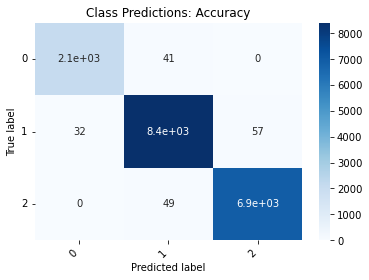

In [52]:
conmat = confusion_matrix(y_test, acc_list[2].predict(x_test))

val = np.mat(conmat) 

classnames = list(set(y_train))

df_cm = pd.DataFrame(

        val, index=classnames, columns=classnames, 

    )


plt.figure()

heatmap = sns.heatmap(df_cm, annot=True, cmap="Blues")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')

heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')

plt.ylabel('True label')

plt.xlabel('Predicted label')

plt.title('Class Predictions: Accuracy')

plt.show()    

## Exporting to Neo4j

In [53]:
# Node : Station
#   Name
#   Latitude and Longitude
#   Max Docks

nodes = df_cur_stations[['Name', 'Latitude', 'Longitude', 'Total docks']]

nodes

,Name,Latitude,Longitude,Total docks
0,175 N Harvard St,42.363796,-71.129164,17
1,2 Hummingbird Lane at Olmsted Green,42.288870,-71.095003,17
2,555 Metropolitan Ave,42.268100,-71.119240,18
3,606 American Legion Hwy at Canterbury St,42.285780,-71.109725,18
4,645 Summer St,42.341781,-71.039870,19
...,...,...,...,...
245,Wentworth Institute of Technology - Huntington...,42.337586,-71.096271,14
246,West End Park,42.365908,-71.064467,35
247,Western Ave at Richardson St,42.361787,-71.143931,0
248,Whittier St Health Center,42.332863,-71.092189,19


In [54]:
import math
from math import radians, cos, sin, asin, sqrt


def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

In [55]:
df_cur_stations.loc[df_cur_stations['Name'].str.contains('JFK')]

,Unnamed: 0,Number,Name,Latitude,Longitude,District,Public,Total docks,Deployment Year
130,235,C32013,JFK/UMass T Stop,42.32034,-71.05118,Boston,Yes,15,2012.0


In [56]:
def get_edges(nodes):
    edges = defaultdict()
    for name in nodes['Name']: #for each station:
        start_row = nodes.loc[nodes['Name'] == name]
        start_lat = start_row['Latitude'].iloc[0]
        start_lon = start_row['Longitude'].iloc[0]
        # get all trips ORIGINATING from current station
        curr_station_trips = df_bluebikes.loc[(df_bluebikes['start station name'] == name)]
        # for all destinations reached from this station:
        for destination in curr_station_trips['end station name'].unique():
            # assigns duration weight to edge between two station
            if name != destination:
                #select all trips between current station and destination station
                trip_durations = curr_station_trips.loc[(df_bluebikes['end station name'] == destination)]['tripduration']
                median_time = trip_durations.median()
                trip_count = trip_durations.__len__()
                if math.isnan (median_time):
                    median_time = -1
                end_row = nodes.loc[nodes['Name'] == destination]
                try:
                    end_lat = end_row['Latitude'].iloc[0]
                    end_lon = end_row['Longitude'].iloc[0]
                    dist = haversine(start_lon, start_lat, end_lon, end_lat)
                except:
                    dist = -1
                edges[(name, destination)] = {"count": trip_count, "time": median_time, "distance": dist}
    return edges

edges = get_edges(nodes)
print(edges)

defaultdict(None, {('175 N Harvard St', 'JFK Crossing at Harvard St. / Thorndike St.'): {'count': 7, 'time': 666.0, 'distance': -1}, ('175 N Harvard St', 'Coolidge Corner - Beacon St at Centre St'): {'count': 1, 'time': 879.0, 'distance': -1}, ('175 N Harvard St', '515 Somerville Ave (Temp. Winter Location)'): {'count': 1, 'time': 2183.0, 'distance': -1}, ('175 N Harvard St', 'Soldiers Field Park - 111 Western Ave'): {'count': 7, 'time': 321.0, 'distance': 0.8960864681318131}, ('175 N Harvard St', 'Harvard University / SEAS Cruft-Pierce Halls at 29 Oxford St'): {'count': 1, 'time': 548.0, 'distance': -1}, ('175 N Harvard St', 'Harvard Square at Mass Ave/ Dunster'): {'count': 2, 'time': 1102.5, 'distance': -1}, ('175 N Harvard St', 'Innovation Lab - 125 Western Ave at Batten Way'): {'count': 1, 'time': 101.0, 'distance': 0.37527353335887714}, ('175 N Harvard St', 'Verizon Innovation Hub 10 Ware Street'): {'count': 1, 'time': 617.0, 'distance': -1}, ('175 N Harvard St', 'Boylston St at E

In [57]:
print(edges.get(('175 N Harvard St', '2 Hummingbird Lane at Olmsted Green')))

None


In [58]:
def strip_station_name(name):
    return name.replace('.', "").replace(" ", "").replace("-", "").replace("/", "").replace("'", "").replace("(", "").replace(")", "").replace("&", "").replace("–", "").replace("@", "").replace(":", "")

In [59]:
def export(df_nodes, edges):
    
    insertString = 'CREATE '

    for n in df_nodes.iterrows():
        strpname = strip_station_name(n[1]["Name"])
        insertString += f'(st{strpname}:Station {{name: "{n[1]["Name"]}", latitude: {n[1]["Latitude"]}, longitude: {n[1]["Longitude"]}, totaldocks: {n[1]["Total docks"]}}}),\n'
    for e in edges:
        strpstart = strip_station_name(e[0])
        strpend = strip_station_name(e[1])
        insertString += f'(st{strpstart})-[:trip {{trip_count: {edges.get(e).get("count")}, duration: {edges.get(e).get("time")}, distance: {edges.get(e).get("distance")}}}]->(st{strpend}),\n'

    return insertString[:-2]

exportString = export(nodes, edges)
print(exportString)

CREATE (st175NHarvardSt:Station {name: "175 N Harvard St", latitude: 42.363796, longitude: -71.129164, totaldocks: 17}),
(st2HummingbirdLaneatOlmstedGreen:Station {name: "2 Hummingbird Lane at Olmsted Green", latitude: 42.28887, longitude: -71.095003, totaldocks: 17}),
(st555MetropolitanAve:Station {name: "555 Metropolitan Ave", latitude: 42.2681, longitude: -71.11924, totaldocks: 18}),
(st606AmericanLegionHwyatCanterburySt:Station {name: "606 American Legion Hwy at Canterbury St", latitude: 42.28578, longitude: -71.109725, totaldocks: 18}),
(st645SummerSt:Station {name: "645 Summer St", latitude: 42.34178089, longitude: -71.03987017, totaldocks: 19}),
(st700CommonwealthAve:Station {name: "700 Commonwealth Ave.", latitude: 42.34960945, longitude: -71.10391524, totaldocks: 16}),
(stAdamsBranchLibrary:Station {name: "Adams Branch Library", latitude: 42.286011, longitude: -71.054689, totaldocks: 0}),
(stAdamsStatLonsdaleSt:Station {name: "Adams St at Lonsdale St", latitude: 42.29167943, l

'\nCODE FOR WRITING UPDATED CYPHER COMMAND: DO NOT UNCOMMENT UNLESS YOU WANT TO RUN EVERY SINGLE CELL BEFOREHAND\ntext_file = open("data/cyphercommand.txt", "w")\ntext_file.write(exportString)\ntext_file.close()\n'

In [61]:
"""
CODE FOR WRITING UPDATED CYPHER COMMAND: DO NOT UNCOMMENT UNLESS YOU WANT TO RUN EVERY SINGLE CELL BEFOREHAND

text_file = open("data/cyphercommand.txt", "w")
text_file.write(exportString)
text_file.close()
"""


In [62]:
uri = "bolt://localhost:7687"
auth = ("neo4j", "password") # substitute your own here
graphDB_Driver  = GraphDatabase.driver(uri, auth = (auth[0], auth[1]))

with graphDB_Driver.session() as graphDB_Session:

    # Create nodes and edges
    graphDB_Session.run(export(nodes, edges))
    graphDB_Session.run("MATCH (j) WHERE size(labels(j)) = 0 DETACH DELETE j;")